# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

In [1]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_core import Tesseract
from utils import MMAOptimizer, hex_grid, plot_grid, plot_grid_slice, plot_mesh

from tesseract_jax import apply_tesseract

The Mapdl server and the spaceclaim tesseract are both running on a remote machine. Hence we define the host and URLs here.

In [2]:
spaceclaim_host = "172.26.3.35"
mapdl_host = spaceclaim_host
spaceclaim_loc = "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe"

spaceclaim_port = 443
mapdl_port = 50052

spaceclaim_url = f"http://{spaceclaim_host}:{spaceclaim_port}"

In [3]:
design_tess = Tesseract.from_image("sdf_fd_tess")
design_tess.serve()

fem_tess = Tesseract.from_image("pymapdl_tess")
fem_tess.serve()

## Design Space

We start by settuping the relevant parameters and a few ICs for the optimization.

In [4]:
grid_fin_params = {
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

rng_key = jax.random.key(0)
grid_fins_rand = jax.random.uniform(rng_key, 16) * 2.0 * jnp.pi

grid_fins_grid = [
    0.84107417,
    5.44211113718,
    1.3466961,
    4.93648920718,
    1.7948966,
    4.48828870718,
    2.30051849,
    3.98266681718,
    0.19739674,
    2.94419591359,
    0.72972216,
    2.41187049359,
    6.08578856718,
    3.33898939359,
    5.55346314718,
    3.87131481359,
]

init_diffable_params_rnd = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_rand).flatten(),
    ]
).astype(jnp.float32)

init_diffable_params_grid = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        jnp.array(grid_fins_grid).flatten(),
    ]
).astype(jnp.float32)


non_diffable_params = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

ERROR:2025-11-27 15:58:03,598:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE


In [5]:
Nx, Ny, Nz = 100, 80, 3
Lx, Ly, Lz = 50, 40, 2


normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params_rnd = normalize(
    init_diffable_params_rnd, normalization_factors, normalization_bias
)

init_diffable_params_grid = normalize(
    init_diffable_params_grid, normalization_factors, normalization_bias
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_params,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        spaceclaim_loc,
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": {"type": "url", "ref": spaceclaim_url},
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

Lets obtain the randomized geometry from the design space.

In [6]:
design_out_rnd = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_rnd,
        **design_inputs,
    },
)
sdf_rnd = design_out_rnd["sdf"]
surface_mesh_rnd = design_out_rnd["mesh"]

num_vertices = surface_mesh_rnd["n_points"]
num_faces = surface_mesh_rnd["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_rnd["points"][:num_vertices]
faces = surface_mesh_rnd["faces"][:num_faces]

mesh_rnd = {
    "points": surface_mesh_rnd["points"][:num_vertices],
    "faces": surface_mesh_rnd["faces"][:num_faces],
}

Number of vertices: 222
Number of faces: 500


Using matplotlib and a helper function we can visualize the generated triangular mesh.

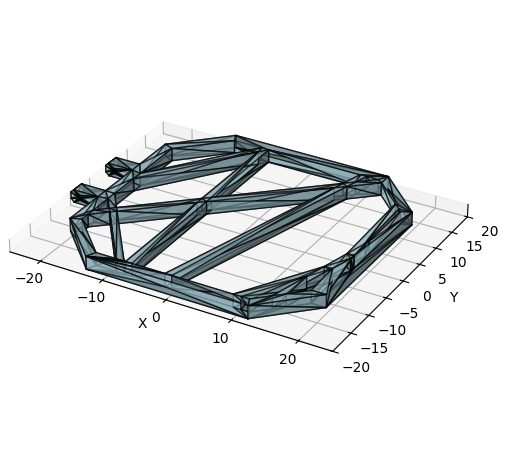

In [7]:
plot_mesh(mesh_rnd, [Lx, Ly, Lz], figsize=(8, 5))

And the corresponding signed distance field (SDF).

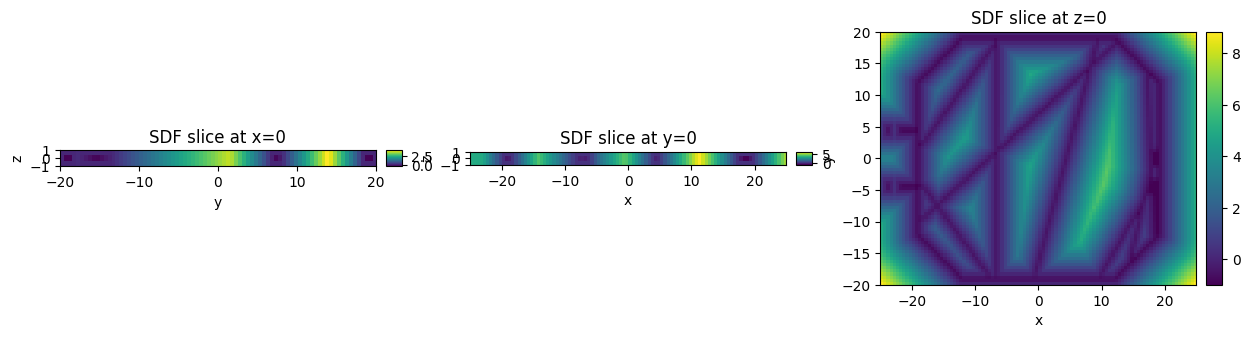

In [8]:
plot_grid(sdf_rnd, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

Lets repeat the same for the grid like initialization.

In [9]:
design_out_grid = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_grid,
        **design_inputs,
    },
)
sdf_grid = design_out_grid["sdf"]
surface_mesh_grid = design_out_grid["mesh"]

num_vertices = surface_mesh_grid["n_points"]
num_faces = surface_mesh_grid["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh_rnd["points"][:num_vertices]
faces = surface_mesh_rnd["faces"][:num_faces]

mesh_grid = {
    "points": surface_mesh_grid["points"][:num_vertices],
    "faces": surface_mesh_grid["faces"][:num_faces],
}

Number of vertices: 304
Number of faces: 712


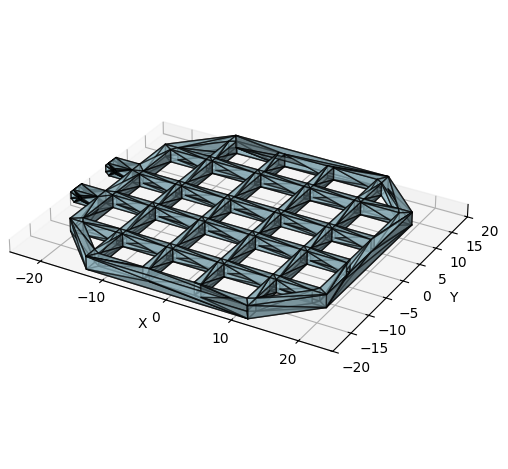

In [10]:
plot_mesh(mesh_grid, [Lx, Ly, Lz], figsize=(8, 5))

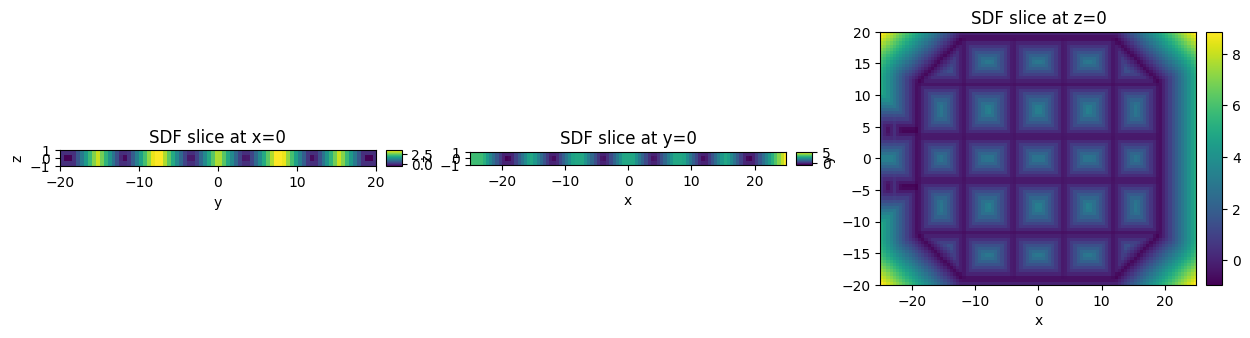

In [11]:
plot_grid(sdf_grid, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 3.466034925736494e-08, rho max: 0.9241418242454529


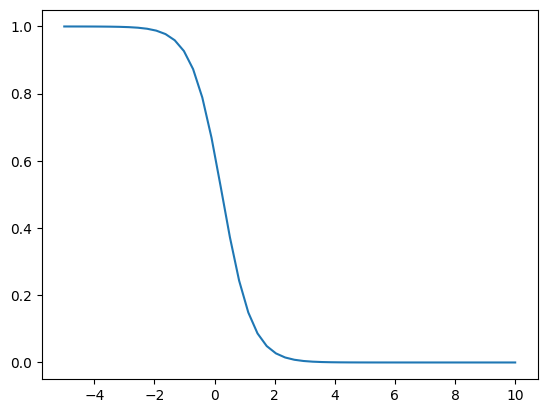

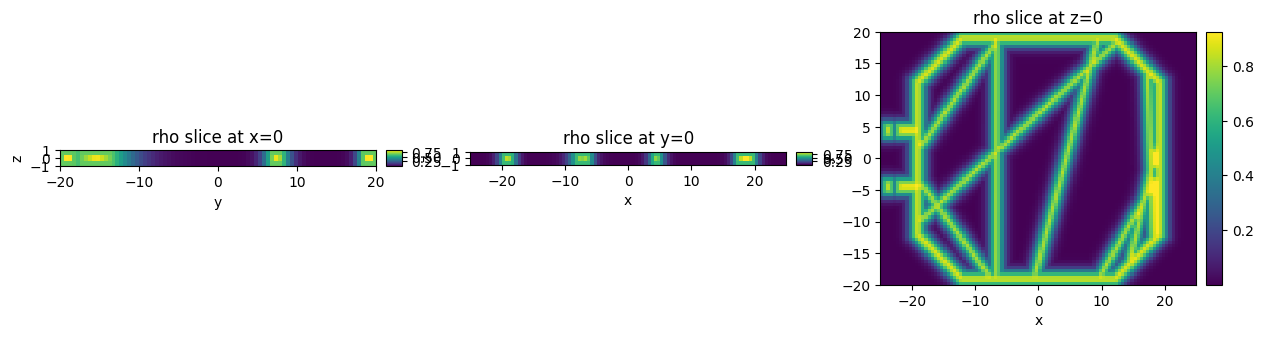

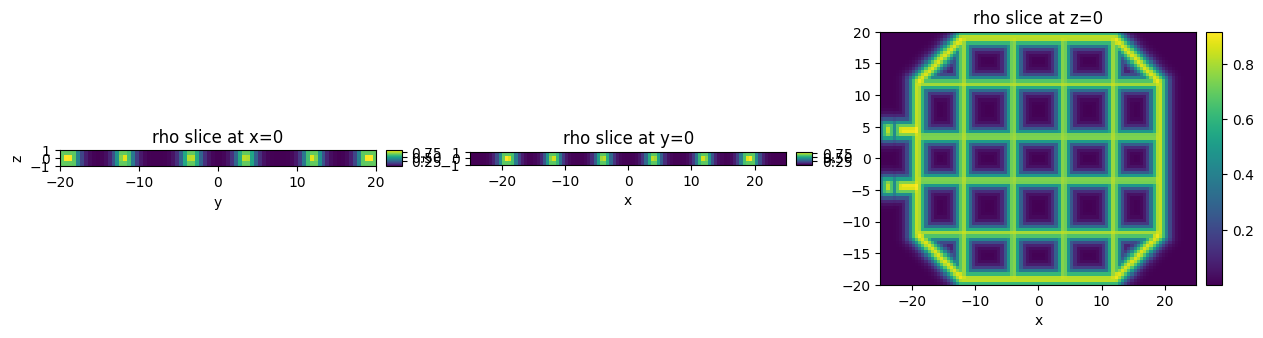

In [12]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 2
rho_offset = 0.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho_rnd = sdf_to_rho(sdf_rnd, scale=rho_scale, offset=rho_offset)
rho_grid = sdf_to_rho(sdf_grid, scale=rho_scale, offset=rho_offset)

plot_grid(rho_rnd, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
plot_grid(rho_grid, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho_rnd)}, rho max: {jnp.max(rho_rnd)}")

## Hex Mesh

As a next step, we create a hex mesh that is just a regular grid of voxel cells. Each density value is then associated with one cell in the grid.

In [13]:
points, cells = hex_grid(Lx, Ly, Lz, Nx + 1, Ny + 1, Nz + 1)

hex_mesh = {
    "points": points,
    "faces": cells,
    "n_points": jnp.array(points.shape[0]),
    "n_faces": jnp.array(cells.shape[0]),
}

We can look at the density values and the hex mesh cell center positions using a 3D scatter plot.

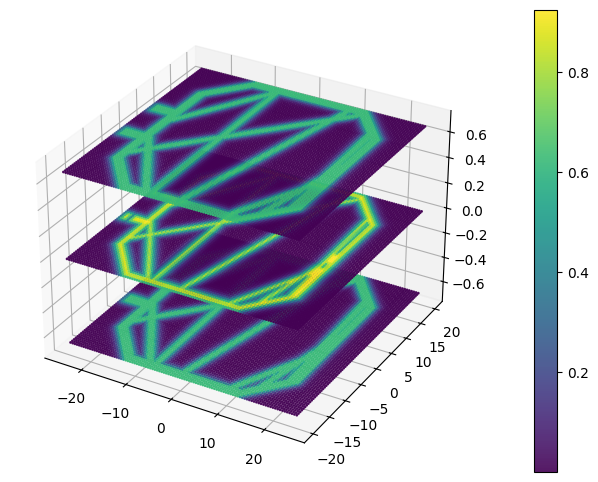

In [14]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho_rnd.flatten()
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=1,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

## Boundary Conditions

In [15]:
def get_boundary_masks(mesh: dict, Lx: float, Ly: float, Lz: float, sdf: jnp.ndarray):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Ly: Size of the domain in y-direction.
        Lz: Size of the domain in z-direction.
        sdf: Signed distance field

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = jnp.logical_and(
        pts[:, 0] <= -Lx / 2 + Lx / 12, sdf.flatten() < 0.5
    )
    von_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 7.6, atol=Lx / 64), sdf.flatten() < 0.5
    )

    return dirichlet_mask, von_neumann_mask


sdf_points = jnp.pad(sdf_rnd, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Ly, Lz, sdf_points)

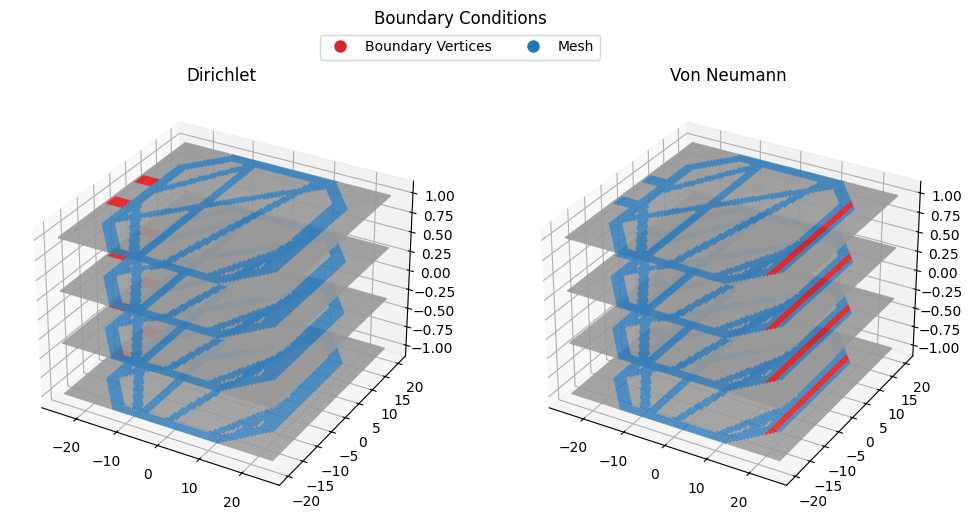

In [16]:
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

plt.suptitle("Boundary Conditions")

sdf_points = jnp.pad(sdf_rnd, [[0, 1], [0, 1], [0, 1]], mode="symmetric")
base = jnp.where(sdf_points.flatten() < 0.5, 0.2, 0.6)

pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[0].set_title("Dirichlet")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, base),
    s=0.7,
    alpha=0.8,
    cmap="Set1",
)
axs[1].set_title("Von Neumann")


# Create proxy artists for the legend
neumann_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Boundary Vertices",
    markerfacecolor="tab:red",
    markersize=10,
)
base_proxy = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Mesh",
    markerfacecolor="tab:blue",
    markersize=10,
)

# Add a single legend for the figure
fig.legend(
    handles=[neumann_proxy, base_proxy],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.95),  # Adjust position as needed
    ncol=3,
)  # Number of columns in the legend

## Finite Element Analysis

In [17]:
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

dirichlet_idx = jnp.where(dirichlet_mask)[0]
von_neumann_idx = jnp.where(von_neumann_mask)[0]
von_neumann_values = jnp.array([0, 0.0, 0.1]) / len(von_neumann_idx) + jnp.zeros(
    (von_neumann_idx.shape[0], 3)
)

fem_inputs = {
    "dirichlet_mask": dirichlet_idx,
    "dirichlet_values": jnp.zeros(dirichlet_idx.size),
    "van_neumann_mask": von_neumann_idx,
    "van_neumann_values": von_neumann_values,
    "hex_mesh": hex_mesh,
    "host": str(mapdl_host),
    "port": str(mapdl_port),
    "E0": 1.0,
    "rho_min": 1e-6,
    "log_level": "DEBUG",
    "vtk_output": "mesh_density.vtk",
}

Lets compute the compliance for both initial conditions.

In [18]:
fem_out_rnd = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_rnd.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance random: {fem_out_rnd['compliance']:.4f}")

Compliance random: 236.5405


In [19]:
fem_out_grid = apply_tesseract(
    fem_tess,
    {"rho": jnp.expand_dims(rho_grid.flatten(), axis=-1), **fem_inputs},
)

print(f"Compliance grid: {fem_out_grid['compliance']:.4f}")

Compliance grid: 156.6433


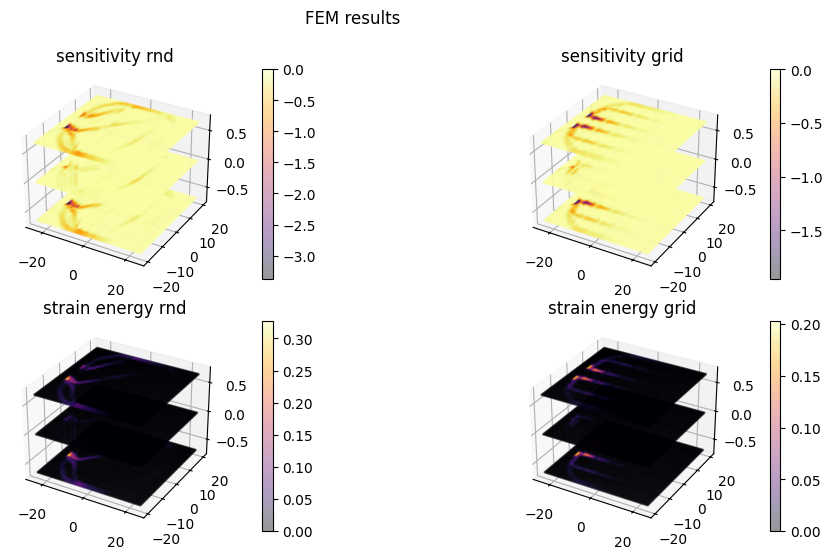

In [20]:
fig, axs = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
plt.suptitle("FEM results")

pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)

scat1 = axs[0, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_rnd["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 0].set_title("sensitivity rnd")
cbar = plt.colorbar(scat1, ax=axs[0, 0], pad=0.1)

scat2 = axs[1, 0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_rnd["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 0].set_title("strain energy rnd")
cbar = plt.colorbar(scat2, ax=axs[1, 0], pad=0.1)

scat1 = axs[0, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["sensitivity"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[0, 1].set_title("sensitivity grid")
cbar = plt.colorbar(scat1, ax=axs[0, 1], pad=0.1)

scat2 = axs[1, 1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=fem_out_grid["strain_energy"],
    s=0.7,
    alpha=0.4,
    cmap="inferno",
)
axs[1, 1].set_title("strain energy grid")
cbar = plt.colorbar(scat2, ax=axs[1, 1], pad=0.1)

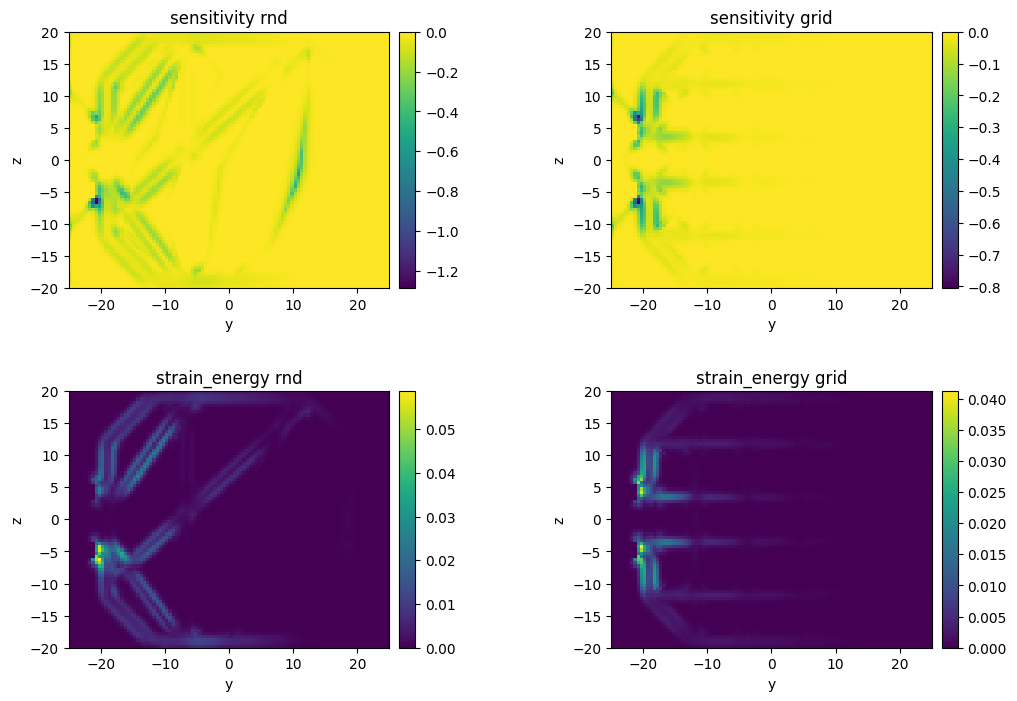

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

mesh_star = hex_mesh

pts_coords = mesh_star["points"]
hex_cells = mesh_star["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

plot_grid_slice(
    fem_out_rnd["sensitivity"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="sensitivity rnd",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_rnd["strain_energy"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="strain_energy rnd",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_grid["sensitivity"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="sensitivity grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    fem_out_grid["strain_energy"].reshape(Nx, Ny, Nz)[..., Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="strain_energy grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.0, hspace=0.4)

## Optimization Setup

In [ ]:
def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

    compliance = apply_tesseract(
        fem_tess,
        {"rho": jnp.expand_dims(rho.flatten(), axis=-1), **fem_inputs},
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    return compliance, {"sdf": sdf, "rho": rho, "surface_mesh": surface_mesh}


grad_fn = jax.value_and_grad(loss, has_aux=True)

## Optimization

In [24]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
    mode: str = "mma",
) -> tuple[list, list, list]:
    # set design bounds by a perturbation value 'delta'
    param_min = diffable_params.copy()
    param_max = diffable_params.copy()

    # the cutting planes do not change
    param_min = param_min.at[0].subtract(1.0e-3)
    param_min = param_min.at[1].subtract(1.0e-3)

    # the bars are free to rotate 2pi from their starting point
    theta_min = -2
    theta_max = 3
    for i in range(2, len(diffable_params)):
        param_min = param_min.at[i].set(theta_min)
        param_max = param_max.at[i].set(theta_max)

    # A placeholder is used for constraint
    num_constraints = 0
    g = jnp.zeros((0, 1))
    dgdx = jnp.zeros((0, diffable_params.shape[0]))

    # initialize the optimizer
    x_update_limit = 0.001  # 0.001 was okay, 0.01 was too much, 0.005 noisy but okay over 20 steps, 0
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []
    if mode == "mma":
        optimizer = MMAOptimizer(
            diffable_params[:, None],
            param_min[:, None],
            param_max[:, None],
            num_constraints,
            x_update_limit=x_update_limit,
        )
    elif mode == "adam":
        schedule = optax.exponential_decay(
            init_value=0.01,
            transition_steps=iterations,
            decay_rate=0.9,
            staircase=False,
        )
        optmizer = optax.adam(learning_rate=schedule)
        opt_state = optmizer.init(params)
    else:
        raise Exception("Invalid argument.")

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)
        print(f"params: {params}")
        print(f"grads: {grads}")

        if mode == "mma":
            print("using mma")
            np_params = optimizer.calculate_next_x(
                loss_value, grads, g, dgdx, i + 1, params
            )
            params = jnp.array(np_params.flatten())

        elif mode == "adam":
            print("using adam")
            grads = grads / jnp.max(grads)
            updates, opt_state = optmizer.update(
                grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
            )
            params = optax.apply_updates(params, updates)
            params = params.at[0:2].set(diffable_params[0:2])

        print(f"params after update: {params}")
        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

In [25]:
loss_hist_grid_adam, params_hist_grid_adam, aux_hist_grid_adam = optimize(
    init_diffable_params_grid, iterations=20, mode="adam"
)

Storing values in hash 2000
Storing values in hash 1000
params: [0.2        0.2        0.133929   0.8665781  0.21444204 0.7860651
 0.28581154 0.71469563 0.36632457 0.6341826  0.0314326  0.468821
 0.11619779 0.3840558  0.96907455 0.5316862  0.88430935 0.6164513 ]
grads: [ 571.4181      22.793045    -7.024564     3.89298    -15.449978
    7.1906476   -2.2200906  -15.713609    32.686886   -64.987206
   16.047653   -32.794434    72.364716  -530.0901     -18.218391
  -23.99936    -38.548203   487.64117  ]
using adam
params after update: [0.2        0.2        0.14392893 0.8565782  0.22444198 0.7760652
 0.29581144 0.72469556 0.35632464 0.6441825  0.02143267 0.47882092
 0.10619786 0.39405572 0.9790745  0.5416861  0.8943093  0.6064514 ]
Iteration 1, Loss: 156.6433
Storing values in hash 2001
Storing values in hash 1001
params: [0.2        0.2        0.14392893 0.8565782  0.22444198 0.7760652
 0.29581144 0.72469556 0.35632464 0.6441825  0.02143267 0.47882092
 0.10619786 0.39405572 0.9790745  0.

Text(0.5, 1.0, 'Compliance over Optimization for rnd using MMA')

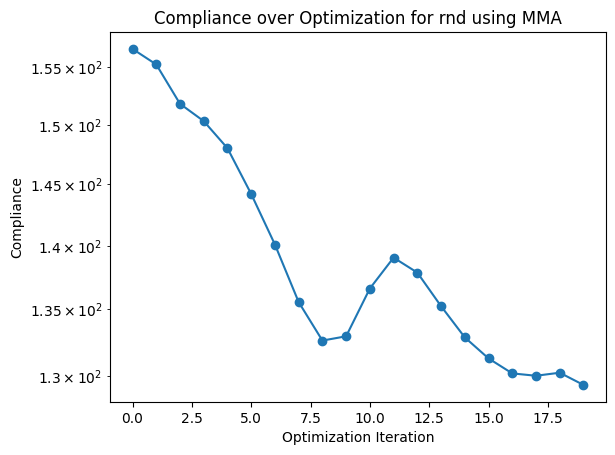

In [26]:
plt.plot(loss_hist_grid_adam, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization for rnd using MMA")

### Optimization Postprocess

In [ ]:
from matplotlib import animation

fig = plt.figure(figsize=(7, 4))

ims = []
for aux in aux_hist_grid_adam:
    sdf_star = aux["sdf"]

    im = plt.imshow(
        (sdf_star[:, :, :] > 0).mean(axis=2).T, origin="lower", cmap="viridis"
    )
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_grid_adam.gif", writer="pillow", fps=10)

In [29]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist_grid_adam):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(20):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("mesh_optim.gif", images, fps=10, loop=0)

/tmp/ipykernel_56118/3686167467.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.
Added tmp_img/mesh_optim_005.png to gif.
Added tmp_img/mesh_optim_006.png to gif.
Added tmp_img/mesh_optim_007.png to gif.
Added tmp_img/mesh_optim_008.png to gif.
Added tmp_img/mesh_optim_009.png to gif.
Added tmp_img/mesh_optim_010.png to gif.
Added tmp_img/mesh_optim_011.png to gif.
Added tmp_img/mesh_optim_012.png to gif.
Added tmp_img/mesh_optim_013.png to gif.
Added tmp_img/mesh_optim_014.png to gif.
Added tmp_img/mesh_optim_015.png to gif.
Added tmp_img/mesh_optim_016.png to gif.
Added tmp_img/mesh_optim_017.png to gif.
Added tmp_img/mesh_optim_018.png to gif.
Added tmp_img/mesh_optim_019.png to gif.
